In [8]:
from collections import deque 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from river import cluster
from river import stream
from river.utils import dict2numpy
from collections import Counter
from tqdm import tqdm
import time

# FastCOMPOSE pipeline

In [9]:
class FastCOMPOSE:
    def __init__(self, data, labels, training_set_size):
        self.training_set_size = training_set_size
        self.training_set_data = deque()
        self.training_set_labels = deque()
        
        self.n_clusters = 5
        self.clustering_algorithm = cluster.KMeans(n_clusters=self.n_clusters)
        
        for i, (x, y) in enumerate(stream.iter_array(data, labels)):
            self._train_clustering(x)
            # Add labeled data to the training set
            self._add_data_to_training_set([(x, y)])
            
    def _calculate_accuracy(self, data, labels):
        # Calculate accuracy on current batch
        accuracy = 0
        accuracy_per_class = {label: [] for label in np.unique(labels)}
        
        num_clusters = len(self.clustering_algorithm.centers)
        clusters = {idx: {"data": [], "labels": []} for idx in range(num_clusters)}
        
        for i, (x, y) in enumerate(stream.iter_array(self.training_set_data, self.training_set_labels)):
            cluster = self._predict_clustering(x)
            clusters[cluster]["data"].append(x)
            clusters[cluster]["labels"].append(y)
            
        for i, (x, y) in enumerate(stream.iter_array(data, labels)):
            cluster = self._predict_clustering(x)
            # Predict label using majority voting for the assigned cluster 
            y_pred = max(set(clusters[cluster]["labels"]), key=clusters[cluster]["labels"].count)
            accuracy += (y == y_pred)
            accuracy_per_class[y].append(y == y_pred)
            
        accuracy /= len(data)
        accuracy_per_class = {label: np.mean(scores) for label, scores in accuracy_per_class.items()}
        
        return accuracy, accuracy_per_class
            
    def _add_data_to_training_set(self, labeled_data):
        for x, y in labeled_data:
            if self.training_set_size and len(self.training_set_data) == self.training_set_size:
                self.training_set_data.popleft()
                self.training_set_labels.popleft()
            self.training_set_data.append(dict2numpy(x))
            self.training_set_labels.append(y)
            
    def _train_clustering(self, x):
        self.clustering_algorithm = self.clustering_algorithm.learn_one(x)
            
    def _predict_clustering(self, x):
        cluster = self.clustering_algorithm.predict_one(x)
        return cluster
    
    def _retrain_if_empty_clusters(self, clusters):
        self.n_clusters -= 1
        self.clustering_algorithm = cluster.KMeans(n_clusters=self.n_clusters)
        
        print(f"Number of clusters = {self.n_clusters}")
            
        for i, (x, y) in enumerate(stream.iter_array(self.training_set_data, self.training_set_labels)):
            self._train_clustering(x)
            
    def _train_and_cluster_training_set(self):
        num_clusters = len(self.clustering_algorithm.centers)
        clusters = {idx: {"data": [], "labels": []} for idx in range(num_clusters)}
        
        for i, (x, y) in enumerate(stream.iter_array(self.training_set_data, self.training_set_labels)):
            self._train_clustering(x)
            cluster = self._predict_clustering(x)
            
            clusters[cluster]["data"].append(x)
            clusters[cluster]["labels"].append(y)
        
        return clusters
    
    def _train_and_retrain_on_training_set_when_necessary(self):
        clusters = self._train_and_cluster_training_set()
            
        # If some clusters are empty retrain model with smaller number of clusters
        while np.any([not cluster["labels"] for idx, cluster in clusters.items()]):
            self._retrain_if_empty_clusters(clusters)
            clusters = self._train_and_cluster_training_set()
            
        return clusters
            
    def _cluster_and_label_step(self, data, labels):
        clusters = self._train_and_retrain_on_training_set_when_necessary()
            
        data_with_labels = []
        for i, (x, _) in enumerate(stream.iter_array(data, labels)):
            self._train_clustering(x)
            cluster = self._predict_clustering(x)
            
            # Label example using majority voting for the assigned cluster
            y = max(set(clusters[cluster]["labels"]), key=clusters[cluster]["labels"].count)
            
            clusters[cluster]["data"].append(x)
            clusters[cluster]["labels"].append(y)
            
            data_with_labels.append((x, y))
        
        # Add newly labeled data to the training set
        self._add_data_to_training_set(data_with_labels)
        
    def plot_clusters(self, print_label_counts_in_clusters):
        num_clusters = len(self.clustering_algorithm.centers)
        clusters = {idx: {"data": [], "labels": []} for idx in range(num_clusters)}
        
        data_dim = self.training_set_data[0].shape[0]

        for i, (x, y) in enumerate(stream.iter_array(self.training_set_data, self.training_set_labels)):
            cluster = self._predict_clustering(x)
            clusters[cluster]["data"].append(list(x.values()))
            clusters[cluster]["labels"].append(y)
            
        # Plot 3D data
        if data_dim == 3:
            fig = plt.figure()
            ax = fig.add_subplot(projection='3d')

        for idx, cluster in clusters.items():
            labels = cluster["labels"]
            # Skip empty clusters
            if len(labels) == 0:
                continue
            label = max(set(labels), key=labels.count)
            cluster = np.vstack(cluster["data"])
            # Plot 3D data
            if data_dim == 3:
                ax.scatter(cluster[:, 0], cluster[:, 1], cluster[:, 2], label=label)
            # Plot 2D data
            else:
                plt.scatter(cluster[:, 0], cluster[:, 1], label=label)
                
            if print_label_counts_in_clusters:
                counter = Counter(labels)
                print(dict(counter))
        
        plt.title("Clusters from training set with labels")
        plt.legend()
        plt.show()
                    
    def __call__(self, data, labels):
        self._cluster_and_label_step(data, labels)
        accuracy, accuracy_per_class = self._calculate_accuracy(data, labels)
        return accuracy, accuracy_per_class

In [10]:
def plot_incoming_data(data, labels):
    unique_labels = np.unique(labels)
    data_dim = data.shape[1]
    
    # Plot 3D data
    if data.shape[1] == 3:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
    
    for label in unique_labels:
        # Plot 3D data
        if data_dim == 3:
            ax.scatter(data[labels == label][:, 0], data[labels == label][:, 1], data[labels == label][:, 2], label=label)
        # Plot 2D data
        else:
            plt.scatter(data[labels == label][:, 0], data[labels == label][:, 1], label=label)
    
    plt.title("Data from current batch with labels")
    plt.legend()
    plt.show()

In [11]:
def train_fast_compose(streaming_data, streaming_labels, training_set_size=1000, print_interval=50, print_label_counts_in_clusters=False):
    # Assume first batch (streaming_data[0], streaming_labels[0]) to be labelled to initialize algorithm
    accuracies = []
    accuracies_per_class = {label: [] for label in np.unique(streaming_labels)}
    start = time.time()

    fc = FastCOMPOSE(streaming_data[0], streaming_labels[0], training_set_size)

    for batch_idx, (data, labels) in tqdm(enumerate(zip(streaming_data[1:], streaming_labels[1:]), 1)):
        accuracy, accuracy_per_class = fc(data, labels)
        accuracies.append(accuracy)
        for label, accuracy in accuracy_per_class.items():
            accuracies_per_class[label].append(accuracy)
        # If class not present in current batch set accuracy for that class to None
        for label in accuracies_per_class.keys():
            if label not in accuracy_per_class.keys():
                accuracies_per_class[label].append(None)

    #     print(batch_idx, accuracy)

        if batch_idx % print_interval == 0:
            fc.plot_clusters(print_label_counts_in_clusters)
            plot_incoming_data(data, labels)

    end = time.time()
    print(f"Time elapsed: {end - start}")
    
    plt.plot(accuracies)
    plt.title("Accuracy")
    plt.show()
    
    for label, accuracy in accuracies_per_class.items():
        plt.plot(accuracy, label=f"{label}")
    plt.title("Accuracy per class")
    plt.legend()
    plt.show()
    
    return fc, accuracies, accuracies_per_class

# Experiments 2D

In [63]:
dataset_2d = "./2d_gaussian_data_v2.csv"

In [64]:
gaussian_data_2d = pd.read_csv(dataset_2d)
y_2d = gaussian_data_2d.pop('label').to_numpy()
X_2d = gaussian_data_2d.to_numpy()

In [65]:
X_2d.shape

(26300, 2)

In [66]:
y_2d.shape

(26300,)

In [67]:
for xi, yi in stream.iter_array(X_2d, y_2d):
    print(xi, yi)
    break

{0: 1.3084041099825865, 1: 5.271207619270895} 0


In [68]:
streaming_data_2d = np.split(X_2d, X_2d.shape[0]/100)
streaming_labels_2d = np.split(y_2d, y_2d.shape[0]/100)

In [69]:
streaming_data_2d[0].shape

(100, 2)

In [70]:
streaming_labels_2d[0].shape

(100,)

48it [00:02, 14.29it/s]

{0: 106}
{0: 440, 1: 2}
{0: 115, 1: 144}
{1: 187, 0: 252}
{0: 232, 1: 22}


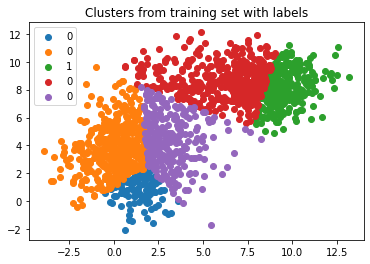

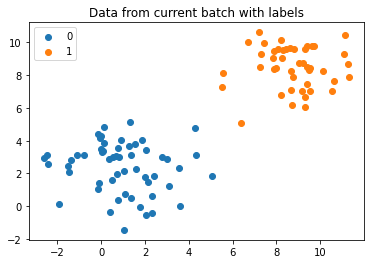

98it [00:06, 13.92it/s]

{0: 230}
{1: 77, 0: 230}
{1: 119, 0: 271}
{0: 136, 1: 163}
{0: 274}


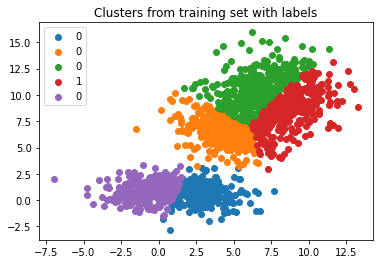

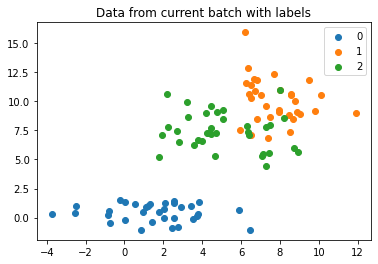

148it [00:10, 13.91it/s]

{0: 363, 1: 40}
{0: 446, 1: 1}
{0: 156, 1: 4}
{0: 200, 1: 27}
{0: 77, 1: 186}


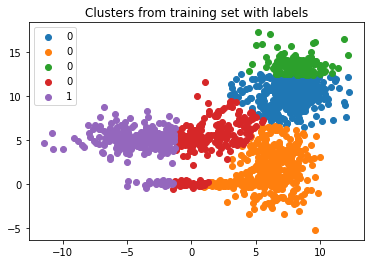

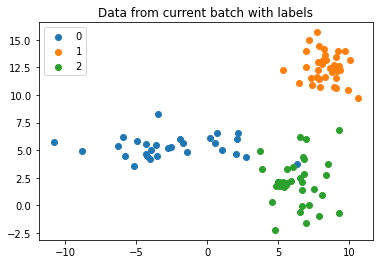

198it [00:14, 14.39it/s]

{0: 354}
{1: 25, 0: 228}
{0: 192}
{0: 515}
{1: 147, 0: 39}


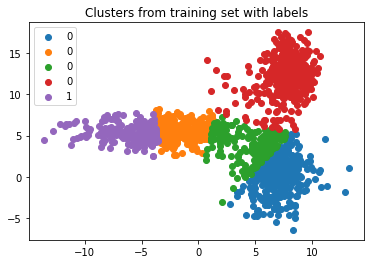

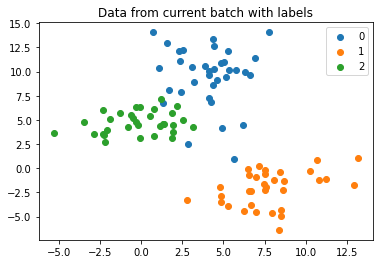

248it [00:18, 14.62it/s]

{0: 313, 1: 4}
{1: 104, 0: 219}
{0: 151, 1: 5}
{0: 189}
{1: 165, 0: 350}


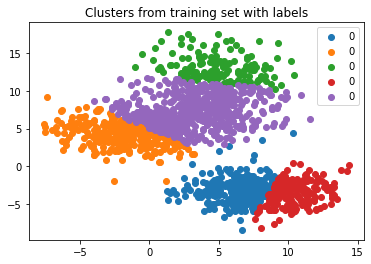

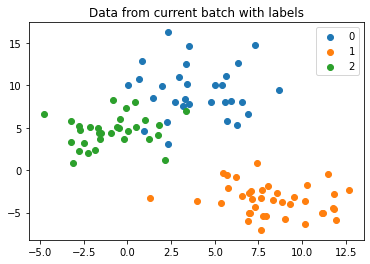

262it [00:19, 13.15it/s]


Time elapsed: 19.92521595954895


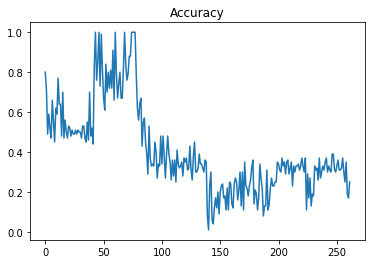

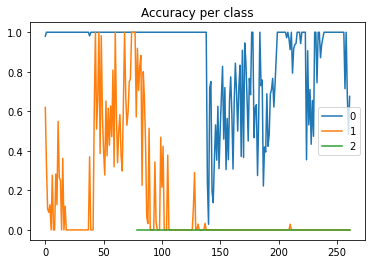

In [71]:
fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_2d, streaming_labels_2d, training_set_size=1500, print_interval=50, print_label_counts_in_clusters=True)

262it [00:18, 14.35it/s]


Time elapsed: 18.256943225860596


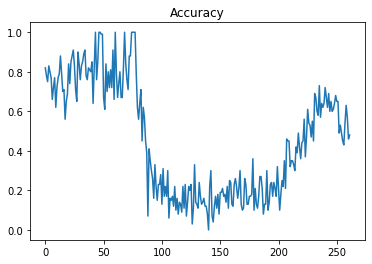

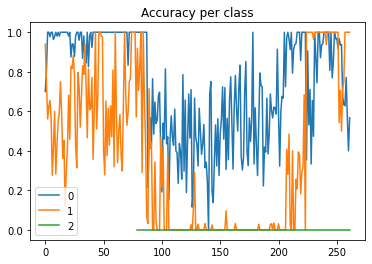

262it [00:18, 14.22it/s]


Time elapsed: 18.433605194091797


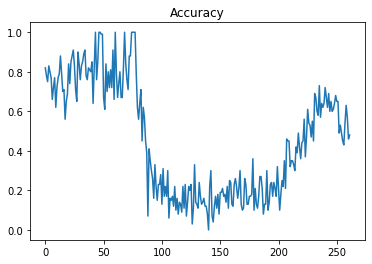

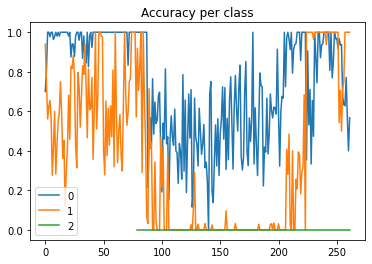

6it [00:00, 51.05it/s]

Number of clusters = 4


262it [00:15, 17.03it/s]


Time elapsed: 15.389648914337158


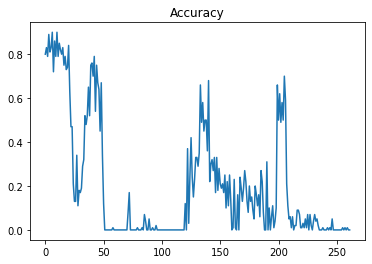

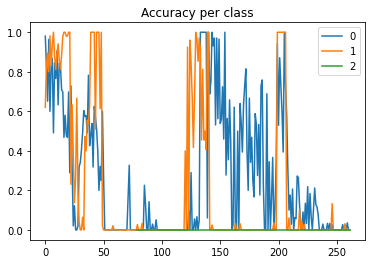

262it [00:18, 14.47it/s]


Time elapsed: 18.116136074066162


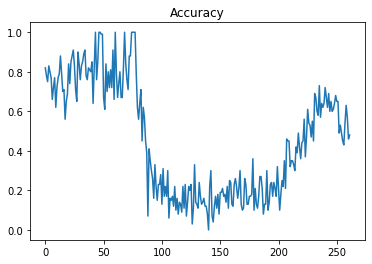

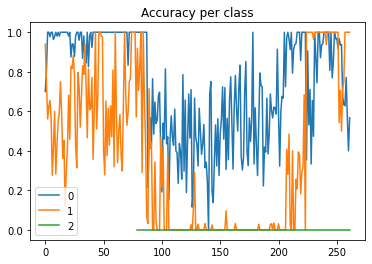

262it [00:17, 14.86it/s]


Time elapsed: 17.639190912246704


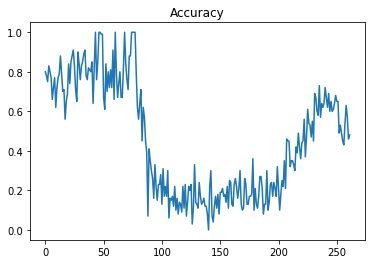

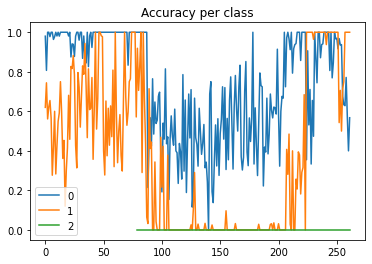

In [72]:
# Obtain averaged results
accuracy_results = []
accuracy_per_class_results = []
for i in range(5):
    fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_2d, streaming_labels_2d, training_set_size=1500, print_interval=1000, print_label_counts_in_clusters=False)
    accuracy_results.append(accuracies)
    accuracy_per_class_results.append(accuracies_per_class)

Text(0.5, 1.0, 'Accuracy averaged over 5 learning trials')

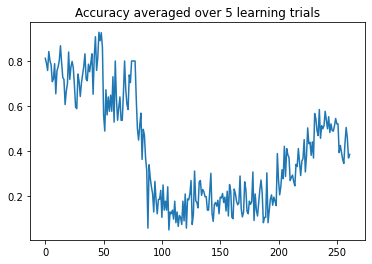

In [73]:
plt.plot(np.array(accuracy_results).mean(axis=0))
plt.title("Accuracy averaged over 5 learning trials")

In [86]:
avg_results_per_class = []
for class_ in range(3):
    result_per_class = np.array([dict_[class_] for dict_ in accuracy_per_class_results if class_ in dict_.keys()], dtype=float)
    avg_result_per_class = np.nanmean(result_per_class, axis=0)
    avg_results_per_class.append(avg_result_per_class)

<ipython-input-86-9865dfc5f3b5>:4: RuntimeWarning: Mean of empty slice
  avg_result_per_class = np.nanmean(result_per_class, axis=0)


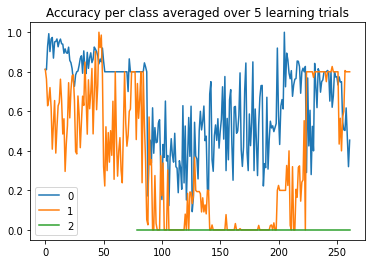

In [88]:
for class_ in range(3):
    plt.plot(avg_results_per_class[class_], label=class_)
    plt.legend()
    plt.title("Accuracy per class averaged over 5 learning trials")

# Training set size tuning

4it [00:00, 31.61it/s]

Number of clusters = 4


48it [00:01, 23.39it/s]

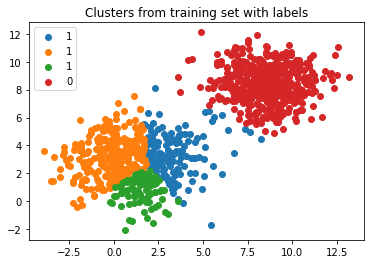

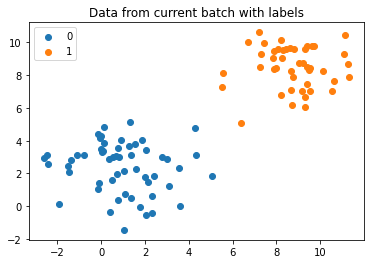

99it [00:04, 23.40it/s]

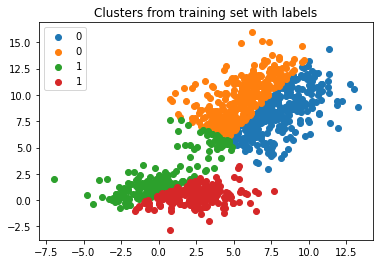

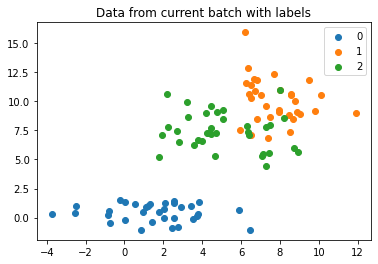

147it [00:06, 23.32it/s]

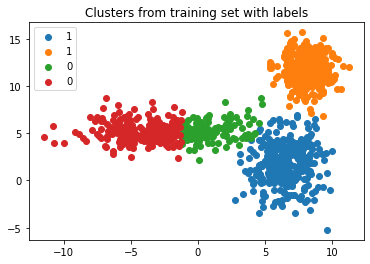

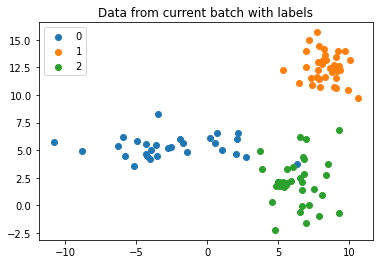

198it [00:09, 24.08it/s]

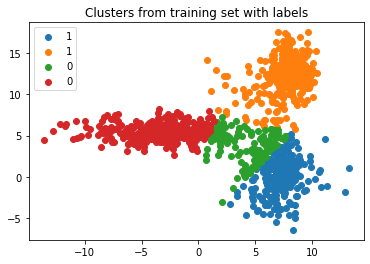

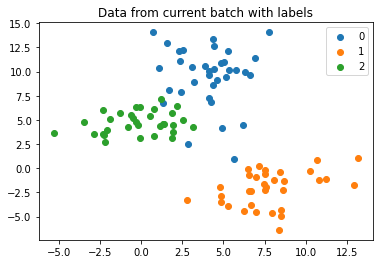

249it [00:11, 23.80it/s]

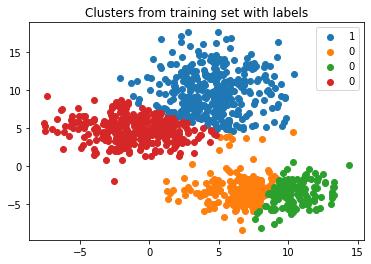

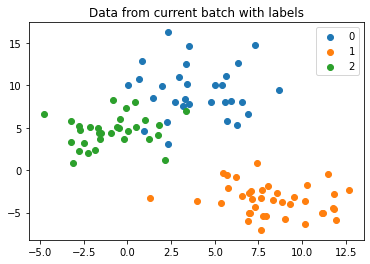

262it [00:12, 20.57it/s]


Time elapsed: 12.741745948791504


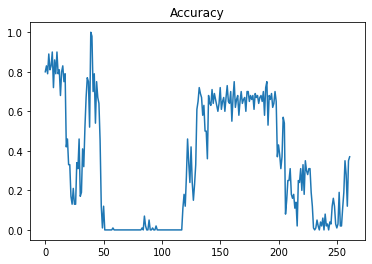

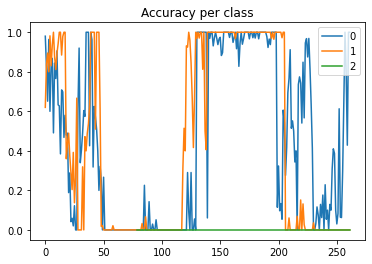

6it [00:00, 46.71it/s]

Number of clusters = 4


48it [00:02, 16.28it/s]

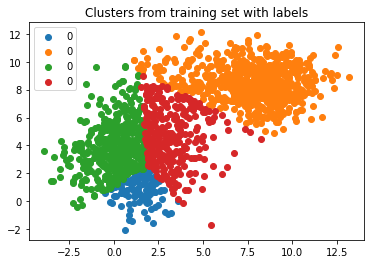

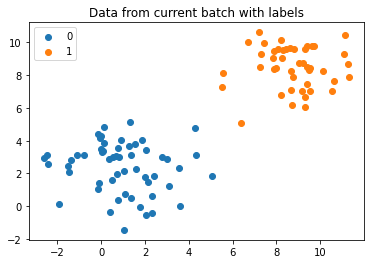

98it [00:05, 16.74it/s]

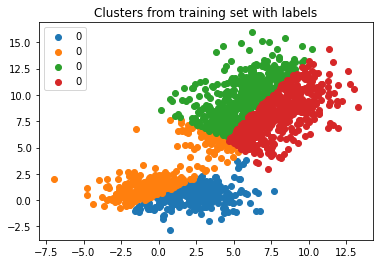

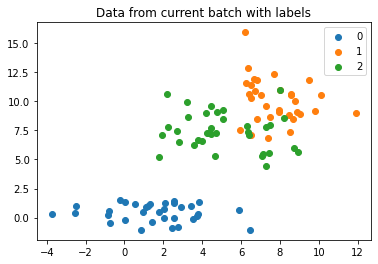

148it [00:09, 17.14it/s]

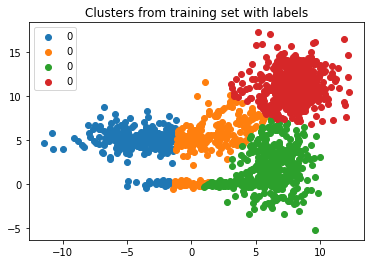

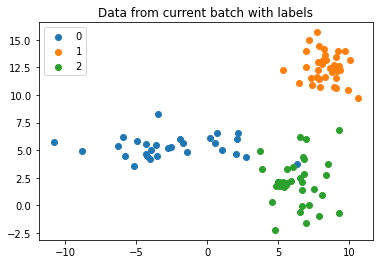

198it [00:12, 16.76it/s]

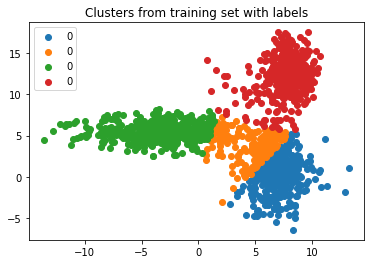

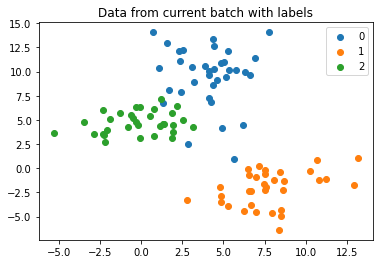

248it [00:15, 16.51it/s]

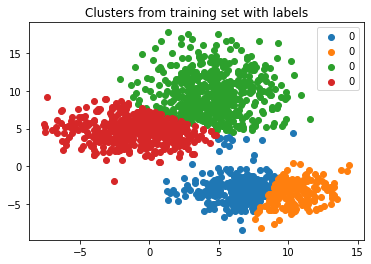

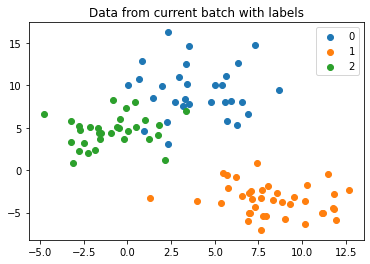

262it [00:17, 15.25it/s]


Time elapsed: 17.189168214797974


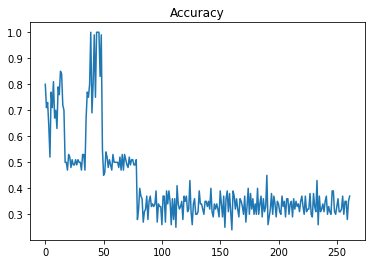

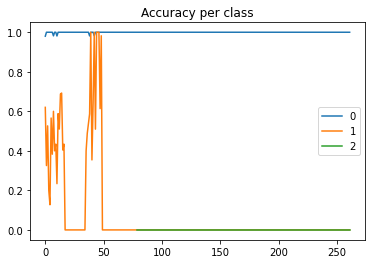

6it [00:00, 47.36it/s]

Number of clusters = 4


49it [00:03, 11.72it/s]

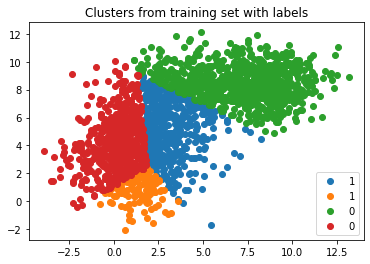

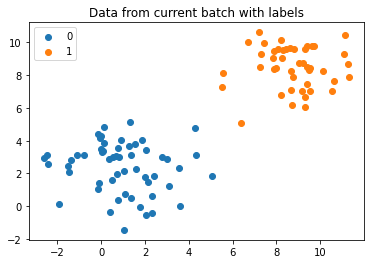

99it [00:07, 12.28it/s]

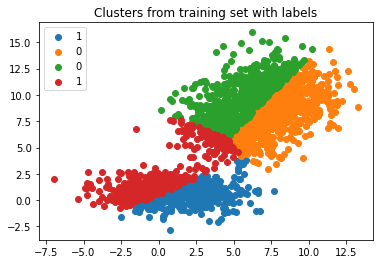

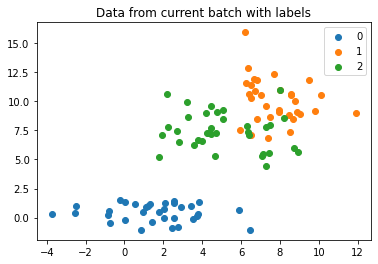

149it [00:12, 12.53it/s]

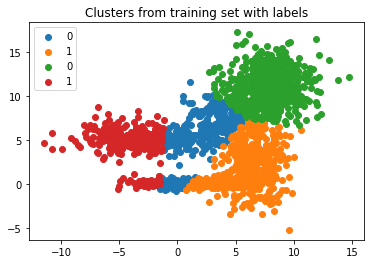

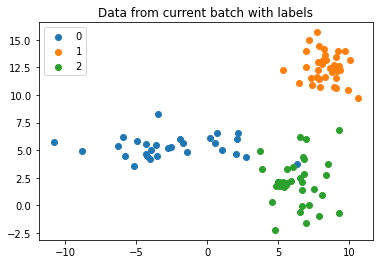

199it [00:16, 12.38it/s]

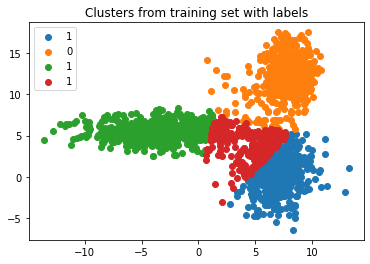

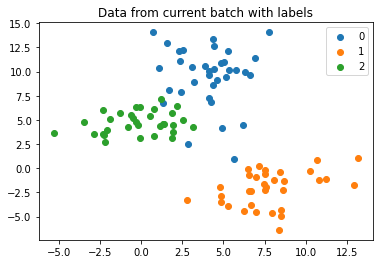

249it [00:20, 12.64it/s]

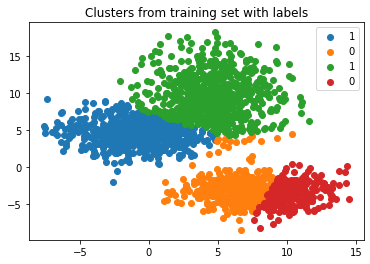

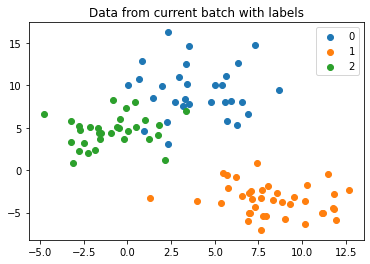

262it [00:22, 11.86it/s]

Time elapsed: 22.09688925743103


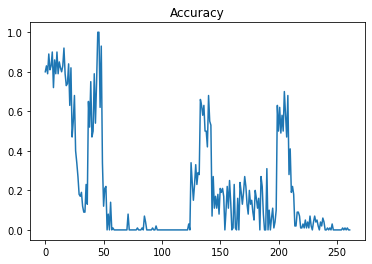

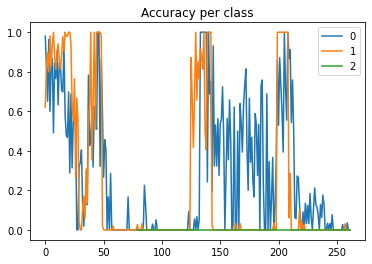

49it [00:05,  4.63it/s]

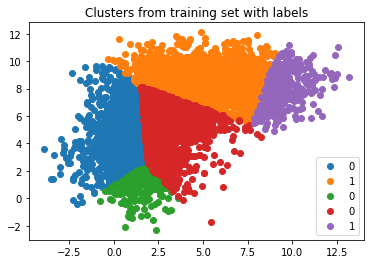

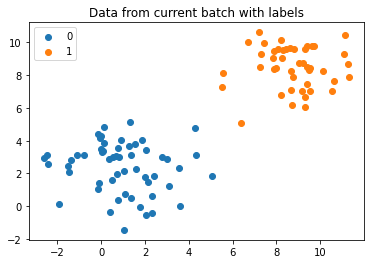

99it [00:23,  2.18it/s]

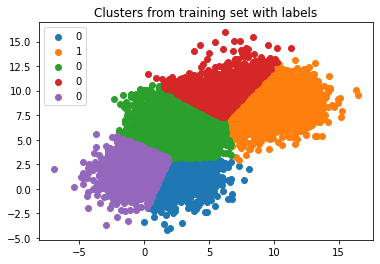

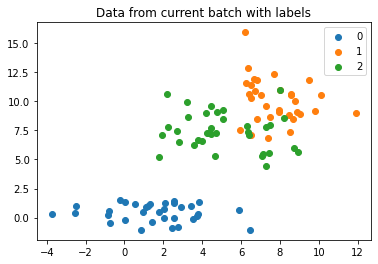

149it [00:52,  1.51it/s]

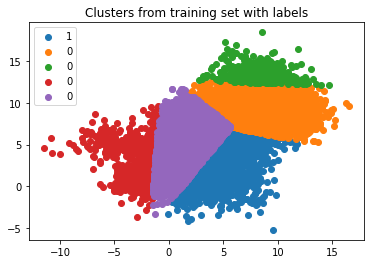

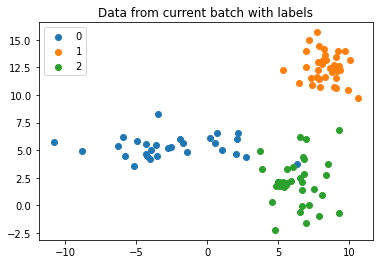

199it [01:33,  1.12it/s]

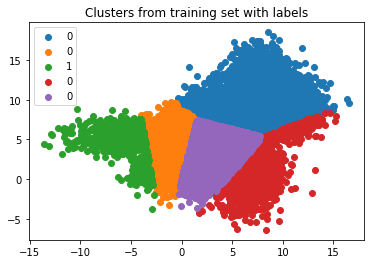

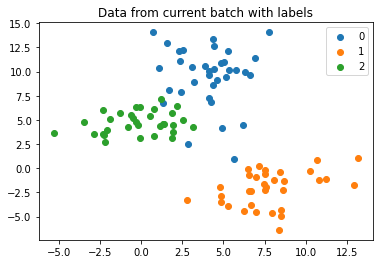

249it [02:24,  1.08s/it]

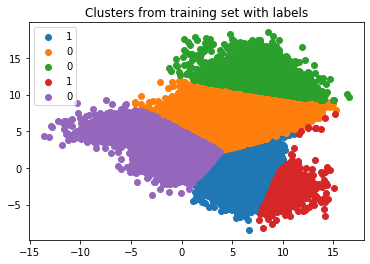

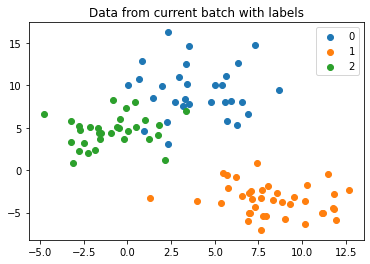

262it [02:39,  1.64it/s]

Time elapsed: 159.67849588394165


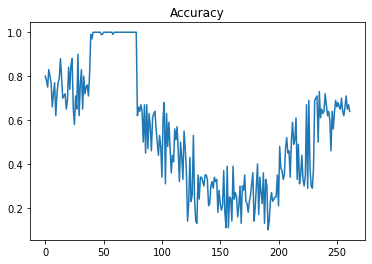

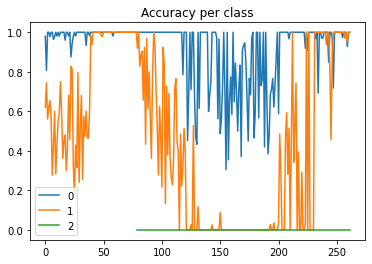

In [51]:
training_set_sizes = [1000, 1500, 2000, None]
for training_set_size in training_set_sizes:
    fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_2d, streaming_labels_2d, training_set_size=training_set_size, print_interval=50, print_label_counts_in_clusters=False)

# Experiments 3D

In [89]:
dataset_3d = "./3d_gaussian_data.csv"
gaussian_data_3d = pd.read_csv(dataset_3d)
y_3d = gaussian_data_3d.pop('label').to_numpy()
X_3d = gaussian_data_3d.to_numpy()

In [90]:
X_3d.shape

(20200, 3)

In [91]:
y_3d.shape

(20200,)

In [92]:
for xi, yi in stream.iter_array(X_3d, y_3d):
    print(xi, yi)
    break

{0: 8.065993314520647, 1: 2.252267979768172, 2: 5.110438424631312} 0


In [93]:
streaming_data_3d = np.split(X_3d, X_3d.shape[0]/100)
streaming_labels_3d = np.split(y_3d, y_3d.shape[0]/100)

In [94]:
streaming_data_3d[0].shape

(100, 3)

In [95]:
streaming_labels_3d[0].shape

(100,)

48it [00:03, 10.79it/s]

{0: 104, 1: 41}
{1: 260, 0: 62}
{1: 222, 0: 99}
{1: 173, 0: 26}
{1: 196, 0: 317}


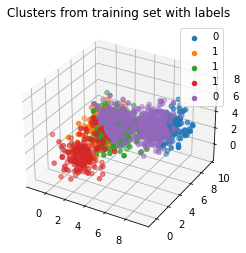

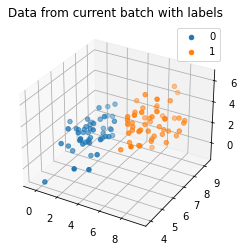

55it [00:05,  6.76it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


99it [00:07, 20.45it/s]

{0: 751}
{1: 749}


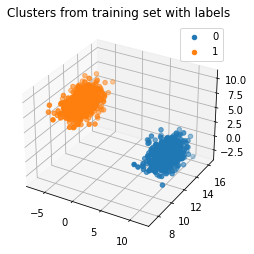

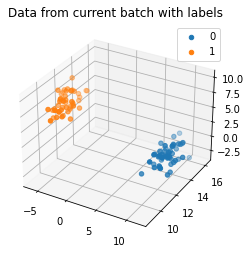

136it [00:09, 19.76it/s]

Number of clusters = 1


147it [00:09, 26.07it/s]

{0: 1500}


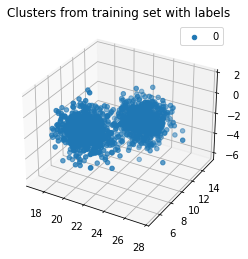

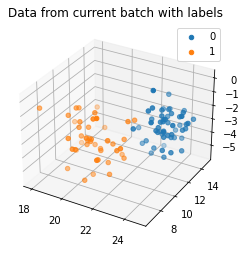

196it [00:11, 30.02it/s]

{0: 1500}


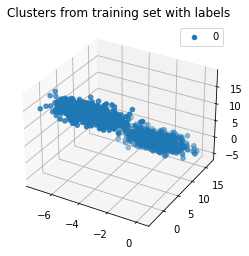

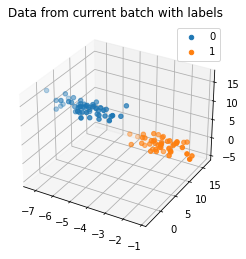

201it [00:12, 16.14it/s]

Time elapsed: 12.455262899398804


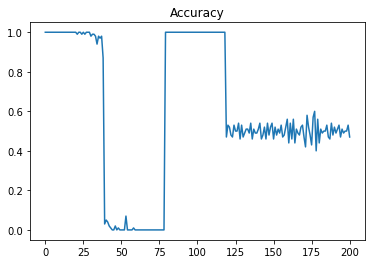

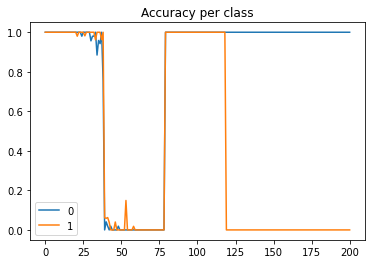

In [98]:
fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_3d, streaming_labels_3d, training_set_size=1500, print_interval=50, print_label_counts_in_clusters=True)

54it [00:04, 11.48it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


139it [00:08, 23.43it/s]

Number of clusters = 1


201it [00:10, 19.35it/s]


Time elapsed: 10.393019914627075


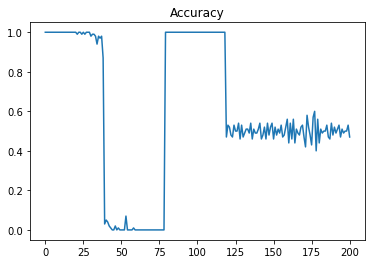

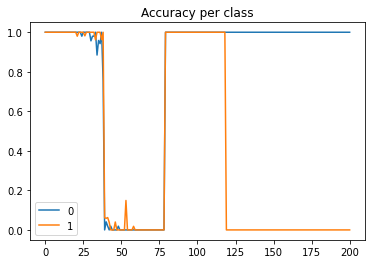

55it [00:04,  8.32it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


137it [00:08, 21.79it/s]

Number of clusters = 1


201it [00:10, 18.87it/s]


Time elapsed: 10.655739068984985


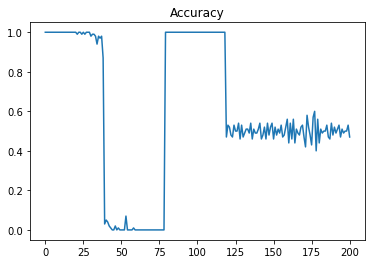

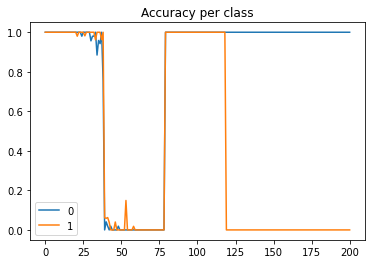

55it [00:04,  8.66it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


139it [00:08, 23.93it/s]

Number of clusters = 1


201it [00:10, 19.02it/s]


Time elapsed: 10.57520604133606


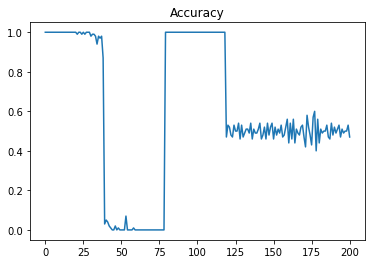

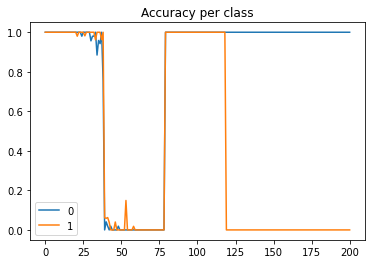

5it [00:00, 43.57it/s]

Number of clusters = 4


56it [00:03, 12.04it/s]

Number of clusters = 3
Number of clusters = 2


139it [00:07, 21.42it/s]

Number of clusters = 1


201it [00:09, 20.30it/s]


Time elapsed: 9.905290126800537


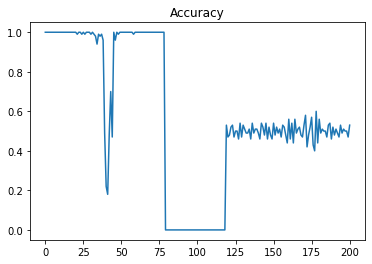

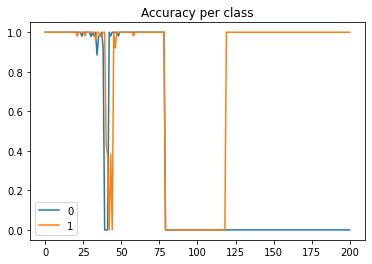

55it [00:04,  9.16it/s]

Number of clusters = 4
Number of clusters = 3
Number of clusters = 2


137it [00:08, 21.24it/s]

Number of clusters = 1


201it [00:10, 19.53it/s]


Time elapsed: 10.296974897384644


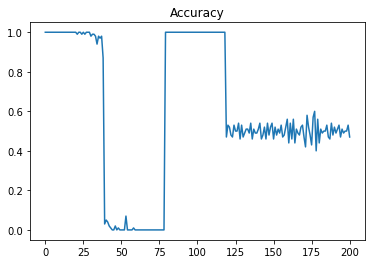

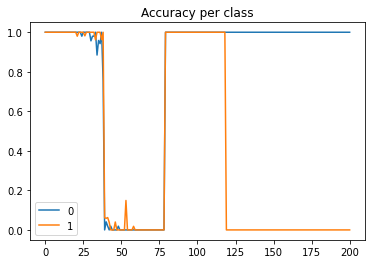

In [99]:
# Obtain averaged results
accuracy_results = []
accuracy_per_class_results = []
for i in range(5):
    fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_3d, streaming_labels_3d, training_set_size=1500, print_interval=1000, print_label_counts_in_clusters=False)
    accuracy_results.append(accuracies)
    accuracy_per_class_results.append(accuracies_per_class)

Text(0.5, 1.0, 'Accuracy averaged over 5 learning trials')

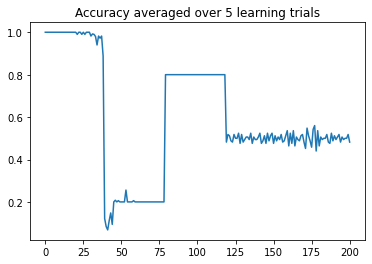

In [100]:
plt.plot(np.array(accuracy_results).mean(axis=0))
plt.title("Accuracy averaged over 5 learning trials")

In [101]:
avg_results_per_class = []
for class_ in range(2):
    result_per_class = np.array([dict_[class_] for dict_ in accuracy_per_class_results if class_ in dict_.keys()], dtype=float)
    avg_result_per_class = np.nanmean(result_per_class, axis=0)
    avg_results_per_class.append(avg_result_per_class)

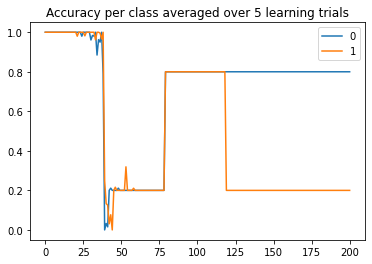

In [102]:
for class_ in range(2):
    plt.plot(avg_results_per_class[class_], label=class_)
    plt.legend()
    plt.title("Accuracy per class averaged over 5 learning trials")

# Experiments 3D with added class

In [12]:
dataset_3d = "./3d_gaussian_data_added_class.csv"
gaussian_data_3d = pd.read_csv(dataset_3d)
y_3d = gaussian_data_3d.pop('label').to_numpy()
X_3d = gaussian_data_3d.to_numpy()

In [13]:
X_3d.shape

(30300, 3)

In [14]:
y_3d.shape

(30300,)

In [15]:
for xi, yi in stream.iter_array(X_3d, y_3d):
    print(xi, yi)
    break

{0: -1.0151555241479664, 1: -1.4161182780401813, 2: 1.951098984742738} 1


In [16]:
streaming_data_3d = np.split(X_3d, X_3d.shape[0]/100)
streaming_labels_3d = np.split(y_3d, y_3d.shape[0]/100)

In [17]:
streaming_data_3d[0].shape

(100, 3)

In [18]:
streaming_labels_3d[0].shape

(100,)

5it [00:00, 47.95it/s]

Number of clusters = 4
Number of clusters = 3


48it [00:02, 17.39it/s]

{0: 493, 1: 6}
{1: 425, 2: 3}
{2: 502, 1: 71}


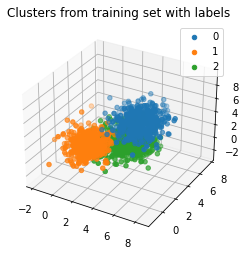

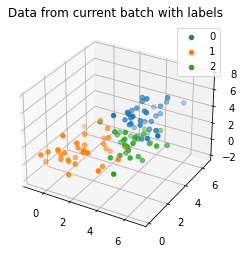

98it [00:05, 17.07it/s]

{1: 506}
{1: 3, 0: 486}
{2: 505}


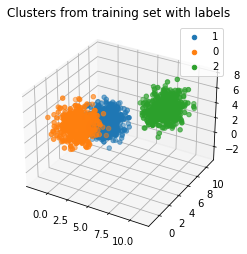

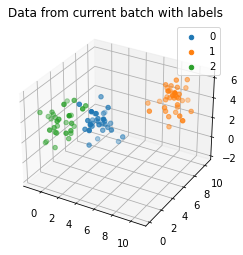

148it [00:09, 17.41it/s]

{2: 491}
{0: 500}
{1: 509}


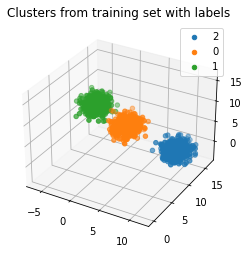

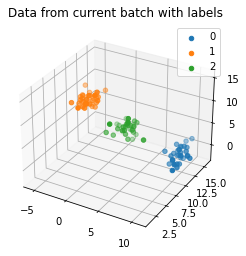

196it [00:12, 16.27it/s]

Number of clusters = 2


199it [00:12, 18.28it/s]

{2: 1000}
{0: 500}


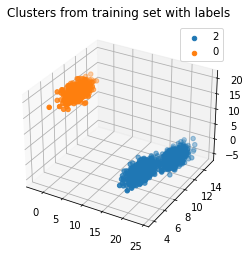

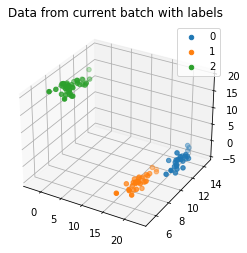

249it [00:14, 22.44it/s]

{2: 635, 0: 1}
{0: 752, 2: 112}


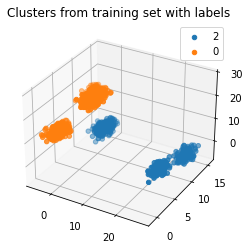

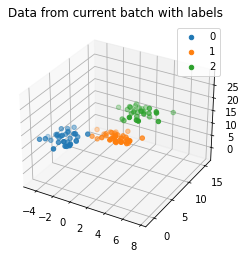

297it [00:17, 22.59it/s]

{2: 498}
{0: 1002}


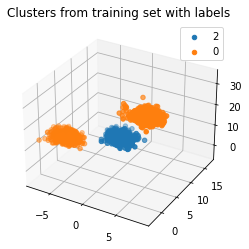

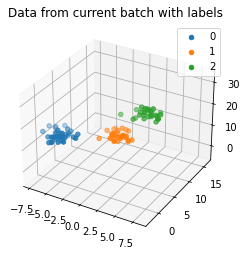

302it [00:17, 16.80it/s]

Time elapsed: 18.01657199859619


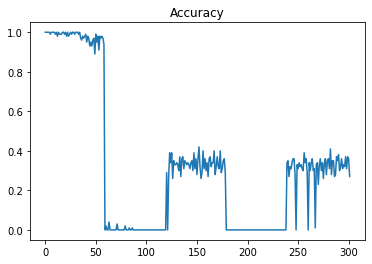

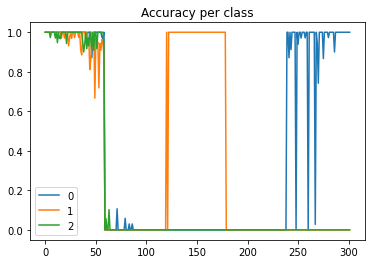

In [19]:
fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_3d, streaming_labels_3d, training_set_size=1500, print_interval=50, print_label_counts_in_clusters=True)

5it [00:00, 43.66it/s]

Number of clusters = 4
Number of clusters = 3


196it [00:11, 15.90it/s]

Number of clusters = 2


302it [00:16, 18.67it/s]


Time elapsed: 16.184984922409058


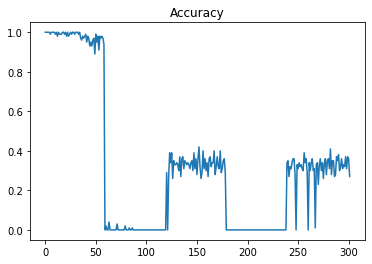

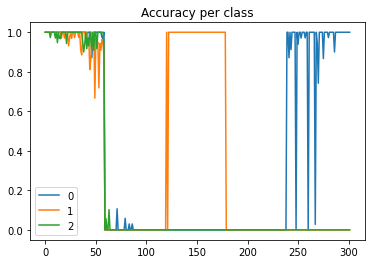

6it [00:00, 49.73it/s]

Number of clusters = 4
Number of clusters = 3


198it [00:11, 18.16it/s]

Number of clusters = 2


302it [00:15, 19.24it/s]

Time elapsed: 15.700039863586426


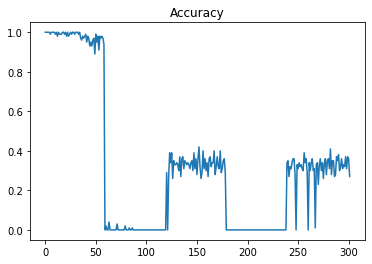

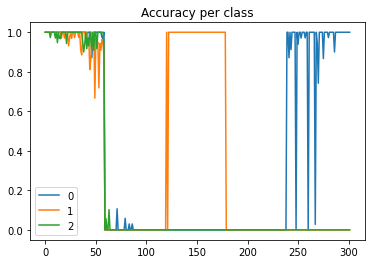

0it [00:00, ?it/s]

Number of clusters = 4


6it [00:00, 49.46it/s]

Number of clusters = 3


198it [00:11, 18.23it/s]

Number of clusters = 2


302it [00:15, 19.29it/s]

Time elapsed: 15.656656265258789


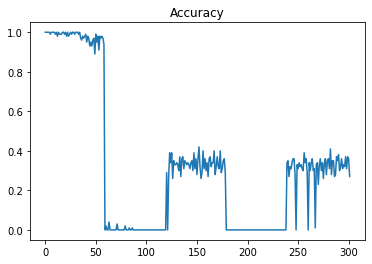

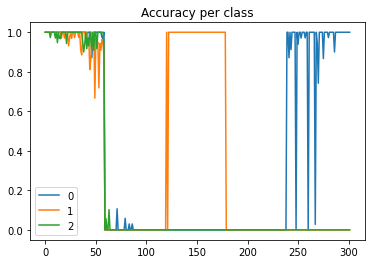

0it [00:00, ?it/s]

Number of clusters = 4


6it [00:00, 48.54it/s]

Number of clusters = 3


198it [00:11, 18.15it/s]

Number of clusters = 2


302it [00:15, 19.21it/s]

Time elapsed: 15.72492790222168


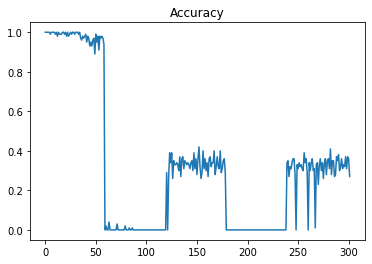

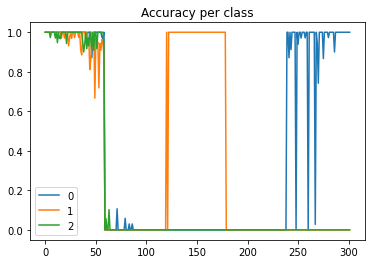

5it [00:00, 32.21it/s]

Number of clusters = 4
Number of clusters = 3


198it [00:11, 18.13it/s]

Number of clusters = 2


302it [00:15, 19.14it/s]

Time elapsed: 15.784260988235474


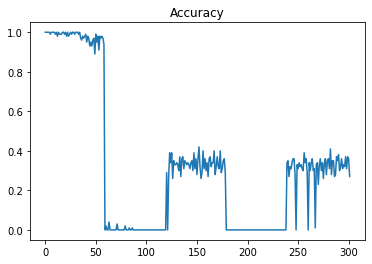

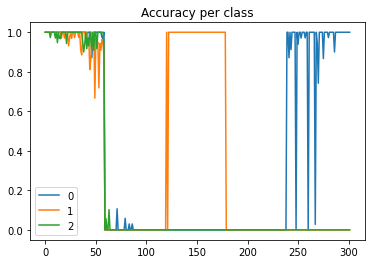

In [20]:
# Obtain averaged results
accuracy_results = []
accuracy_per_class_results = []
for i in range(5):
    fc, accuracies, accuracies_per_class = train_fast_compose(streaming_data_3d, streaming_labels_3d, training_set_size=1500, print_interval=1000, print_label_counts_in_clusters=False)
    accuracy_results.append(accuracies)
    accuracy_per_class_results.append(accuracies_per_class)

Text(0.5, 1.0, 'Accuracy averaged over 5 learning trials')

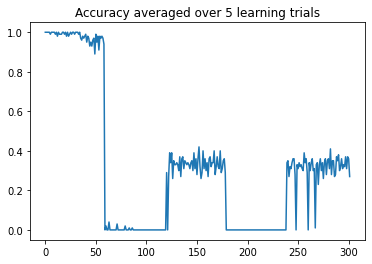

In [21]:
plt.plot(np.array(accuracy_results).mean(axis=0))
plt.title("Accuracy averaged over 5 learning trials")

In [22]:
avg_results_per_class = []
for class_ in range(3):
    result_per_class = np.array([dict_[class_] for dict_ in accuracy_per_class_results if class_ in dict_.keys()], dtype=float)
    avg_result_per_class = np.nanmean(result_per_class, axis=0)
    avg_results_per_class.append(avg_result_per_class)

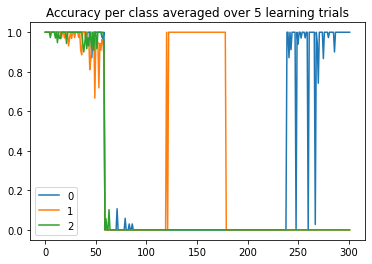

In [23]:
for class_ in range(3):
    plt.plot(avg_results_per_class[class_], label=class_)
    plt.legend()
    plt.title("Accuracy per class averaged over 5 learning trials")